__система машинного перевода, модель SEQ2SEQ с механизмом Attention__ 

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()
np.set_printoptions(precision=2)

# загружаем данные

https://drive.google.com/file/d/166Msc4oTDy2wFWd5_VnuZES3dduvpMD1/view?usp=share_link


In [2]:
# %%time 

# import zipfile
# import requests
# from io import StringIO,BytesIO

# file_id = '166Msc4oTDy2wFWd5_VnuZES3dduvpMD1'
# url = f'https://drive.google.com/uc?id={file_id}'

# with requests.get(url,stream=True) as r:
#     with zipfile.ZipFile(BytesIO(r.content)) as z:
#         with z.open('Rus-Eng-small.tsv') as f:
#             df = pd.read_csv( 
#                 StringIO( str(f.read(),encoding='utf-8' )[1:] ), 
#                 sep='\t',
#                 header=None,
#                 names=['N_Rus','Rus','N_Eng','Eng'] 
#             )


In [3]:
df = pd.read_pickle('data/data.pkl.gz')

In [4]:
display(len(df))
display(df.sample(10))

200000

,N_Rus,Rus,N_Eng,Eng
172727,4023742,Том редко пьёт кофе по вечерам.,2958108,Tom seldom drinks coffee in the evening.
113614,3257110,"Если он вам нравится, можете оставить его себе!",1242881,"If you like it, you can keep it!"
136965,3592109,Все начинания трудны.,1010982,All beginnings are difficult.
92902,2900805,Сегодня я ни в чём не преуспел.,2900803,I wasn't successful at anything today.
85027,2778730,Я думаю поехать в следующем году за границу.,262160,I am thinking of going abroad next year.
33473,1643516,Это было бы здорово.,1897776,That would be great.
114693,661055,Я почти закончил.,2247908,I'm almost finished.
128773,2229726,"Не думаю, что он придёт.",1490724,I don't think he will come.
183701,4143485,Иди работать.,2230781,Go to work.
100375,3015985,Нам придётся что-то с этим делать.,2892428,We're going to have to do something about that.


In [5]:
display( df.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   N_Rus   200000 non-null  int64 
 1   Rus     200000 non-null  object
 2   N_Eng   200000 non-null  int64 
 3   Eng     200000 non-null  object
dtypes: int64(2), object(2)
memory usage: 6.1+ MB


None

In [6]:
# df.to_pickle('tmp/data.pkl')

In [7]:
display( len(df) )
df = df.drop_duplicates('N_Rus').drop_duplicates('N_Eng').reset_index(drop=True)
display( len(df) )

200000

147087

# выбираем пары для обучения модели

## анализ словаря

In [8]:
# !pip install razdel

In [9]:
from razdel import tokenize
from nltk.tokenize import word_tokenize as nltk_tokenize_word

In [10]:
# CountVectorizer(
#     *, 
#     input='content', 
#     encoding='utf-8', 
#     decode_error='strict', 
#     strip_accents=None, 
#     lowercase=True, 
#     preprocessor=None, 
#     tokenizer=None, 
#     stop_words=None, 
#     token_pattern='(?u)\b\w\w+\b', 
#     ngram_range=(1, 1), 
#     analyzer='word', 
#     max_df=1.0, 
#     min_df=1, 
#     max_features=None, 
#     vocabulary=None, 
#     binary=False, 
#     dtype=<class 'numpy.int64'>
# )

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from razdel import tokenize

In [12]:
import re

df['Rus'] = df['Rus'].progress_apply(lambda s: re.sub(r'[«»]','"',s))

  0%|          | 0/147087 [00:00<?, ?it/s]

In [13]:
def tokenizer_ru(s): return [ t.text for t in tokenize(s) ] 

cv_ru = CountVectorizer(
        lowercase=False,
        token_pattern=None,
        tokenizer=tokenizer_ru, 
        min_df=2,
    ).fit(df['Rus'])

vocab_ru = cv_ru.vocabulary_
display( len(vocab_ru) )

vocab_ru_ = (
    pd.DataFrame(
        [ [v,k] for k,v in  vocab_ru.items() ],columns=['index','word']
    )
        .sort_values(by='index')
        .set_index('index')
    )
vocab_ru_['tf'] = cv_ru.transform(df['Rus']).sum(axis=0).T

display( vocab_ru_ )

# vocab_ru_.sort_values(by='tf').to_csv('tmp/vocab_ru.csv',index=False,sep='\t')

display( vocab_ru_[['tf']].describe([.01, .25, .75, .95, .99 ]).T )

29472

,word,tf
index,,
0,!,3818
1,!!!,5
2,!..,3
3,"""",4745
4,$,3
...,...,...
29467,“,9
29468,”,5
29469,„,4


,count,mean,std,min,1%,25%,50%,75%,95%,99%,max
tf,29472.0,34.5985,864.259552,2.0,2.0,2.0,4.0,9.0,61.0,324.58,126855.0


In [14]:
# vocab_ru_.query('tf<2').sort_values(by='tf')

In [15]:
# vocab_ru_.query('tf>188').sort_values(by='tf')

In [16]:
del vocab_ru_

---

In [17]:
# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.tokenize import word_tokenize as nltk_tokenize_word

def tokenizer_en(s): return nltk_tokenize_word(s,language='english') 

cv_en = CountVectorizer(
        lowercase=False,
        token_pattern=None,
        tokenizer=tokenizer_en, 
        min_df=2,
    ).fit(df['Eng'])

vocab_en = cv_en.vocabulary_
display( len(vocab_en) )

vocab_en_ = (
    pd.DataFrame(
        [ [v,k] for k,v in  vocab_en.items() ],columns=['index','word']
    )
        .sort_values(by='index')
        .set_index('index')
    )

vocab_en_['tf'] = cv_en.transform(df['Eng']).sum(axis=0).T

display( vocab_en_ )

# vocab_en_.sort_values(by='tf').to_csv('tmp/vocab_en.csv',index=False,sep='\t')

display( vocab_en_[['tf']].describe([.01, .25, .75, .95, .99 ]).T )

13494

,word,tf
index,,
0,!,3397
1,$,37
2,%,56
3,&,3
4,',207
...,...,...
13489,—,45
13490,‘,23
13491,’,103


,count,mean,std,min,1%,25%,50%,75%,95%,99%,max
tf,13494.0,88.466726,1370.468131,2.0,2.0,3.0,5.0,17.0,168.0,1119.35,127460.0


In [18]:
del vocab_en_

## выделяем тестовый набор

In [19]:
# считаем количество слов
df['Rus_len_seq'] = df['Rus'].progress_apply(lambda s: len( tokenizer_ru(s) )  )
df['Eng_len_seq'] = df['Eng'].progress_apply(lambda s: len( tokenizer_en(s) ) )

  0%|          | 0/147087 [00:00<?, ?it/s]

  0%|          | 0/147087 [00:00<?, ?it/s]

In [20]:
display( df[['Rus_len_seq','Eng_len_seq']].describe([.01, .25, .75, .95, .99 ]).astype(int).T )

,count,mean,std,min,1%,25%,50%,75%,95%,99%,max
Rus_len_seq,147087,7,4,2,3,5,6,8,13,20,173
Eng_len_seq,147087,8,4,2,4,6,7,9,14,22,232


In [21]:
l_min,l_max = 2,14

# выбираем последовательности приблизительно одинаковой длинны
df_train = df.query(f'({l_min}<Rus_len_seq<{l_max})&({l_min}<Eng_len_seq<{l_max})')
display( len(df_train) )
display( df_train.sample(7) )

137523

,N_Rus,Rus,N_Eng,Eng,Rus_len_seq,Eng_len_seq
126222,4000804,Я написал четырёхмиллионное предложение на Тат...,4000002,I wrote the four millionth sentence in Tatoeba.,7,9
49282,2494776,Кто-нибудь здесь говорит по-французски?,2451538,Does anyone here know French?,5,6
46470,2419568,"Он любит её, но она не любит его.",302878,"He loves her, but she doesn't like him.",10,11
105959,3639944,"Ты что, правда не знаешь?",3636508,Do you really not know?,7,6
70402,2890219,Один из игроков был травмирован во время игры.,2890218,One of the players was hurt during the game.,9,10
132479,4080659,Я хочу себе лёгкое весеннее пальто.,2267112,I want a light spring coat.,7,7
43349,2284057,Он работает в лаборатории.,290963,He works in the laboratory.,5,6


In [22]:
df_test = df_train.sample( len(df_train)//10 )
df_train = df_train.drop(df_test.index)

df_val = df_train.sample( len(df_train)//10 )
df_train = df_train.drop(df_val.index)

display( len(df_train), len(df_val), len(df_test) )

111394

12377

13752

# собираем генератор датасета

In [23]:
# vocab_en

In [24]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [25]:
class TextPairDataset(Dataset):

    def __init__(self, df,vocab,cols={'Rus':'russian','Eng':'english'}):
        super().__init__()

        assert len(cols)==2
        assert len(df)>1
        self._lang = cols
        self._data = df[self._lang.keys()].reset_index(drop=True)
        # self._vocab = vocab if vocab
        #         else { k : self._make_vocab(df[k],language=self._lang[k]) for k in self._lang } 
        self._vocab = vocab 
        self._max_seq = { k : self._get_max_seq(df[k],language=self._lang[k]) for k in self._lang }
    
    @staticmethod
    def  _tokenize(s,language):
        return nltk_tokenize_word(s,language=language)

#     @classmethod
#     def _make_vocab(cls,d,language):
#         words = sorted(set.union(*[ set(  cls._tokenize(s,language) ) for s in tqdm(d) ]))
#         return { w:n+1 for n,w in enumerate(words) } | { '<PAD>':0, '<EOS>':len(words)+2, '<UNK>':len(words)+3 }
    
    @classmethod
    def _get_max_seq(cls,d,language):
        return max([ len(cls._tokenize(s,language)) for s in tqdm(d) ])
    
    @property
    def vocab(self):
        return self._vocab

    @vocab.setter
    def vocab(self,vocab):
        self._vocab = vocab

    @property
    def data(self):
        return self._data
        
    def __len__(self):
        return len(self._data)
    
    @property
    def max_seq(self):
        return self._max_seq
    
    def _encode(self,s,language,vocab):
        return [ vocab['<UNK>'] if not(w in vocab) else vocab[w] for w in self._tokenize(s,language) ] 
        
    def _pad_seq(self,s,max_seq,eos_code):
        return [0]*(max_seq-len(s)) + s + [eos_code]
    
    def __getitem__(self, idx):
        return  [
            torch.LongTensor(
                    np.array(
                        self._pad_seq(
                            self._encode( self._data[c][idx], language=self._lang[c] , vocab=self._vocab[c] ) 
                            ,max_seq=self._max_seq[c]
                            ,eos_code=self._vocab[c]['<EOS>']
                        ) 
                        ,dtype=int
                    )
            )
            for c in self._lang 
        ]

----

In [26]:
vocab_ru = { w:n+1 for n,w in enumerate(sorted(vocab_ru.keys())) }
ru_max_idx = max(vocab_ru.values())
vocab_ru =  vocab_ru | { '<PAD>':0, '<EOS>':ru_max_idx+1, '<UNK>':ru_max_idx+2, }
display( len(vocab_ru) )

del ru_max_idx

29475

In [27]:
vocab_en = { w:n+1 for n,w in enumerate(sorted(vocab_en.keys())) }
en_max_idx = max(vocab_en.values())
vocab_en =  vocab_en | { '<PAD>':0, '<EOS>':en_max_idx+1, '<UNK>':en_max_idx+2, }
display( len(vocab_en) )

del en_max_idx

13497

In [28]:
vocab = { 'Rus': vocab_ru, 'Eng': vocab_en, }

In [29]:
del vocab_ru
del vocab_en

---

In [30]:
ds_train = TextPairDataset( df_train, vocab=vocab )

  0%|          | 0/111394 [00:00<?, ?it/s]

  0%|          | 0/111394 [00:00<?, ?it/s]

In [31]:
ds_val = TextPairDataset(df_val, vocab=ds_train.vocab)

  0%|          | 0/12377 [00:00<?, ?it/s]

  0%|          | 0/12377 [00:00<?, ?it/s]

In [32]:
display( ds_train.max_seq, ds_val.max_seq )

{'Rus': 13, 'Eng': 13}

{'Rus': 13, 'Eng': 13}

# строим модель

In [33]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, encoder_hidden_dim,): 
        super(Encoder, self).__init__()
        self._emb = nn.Embedding(vocab_len, embedding_dim)
        self._dp = nn.Dropout(0.2)
        self._rnn = nn.GRU(
                input_size=embedding_dim, 
                hidden_size=encoder_hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )
        
    def forward(self, x):
        o = F.relu( self._emb(x) )
        o = self._dp(o)
        o, h = self._rnn(o)
        return o,h

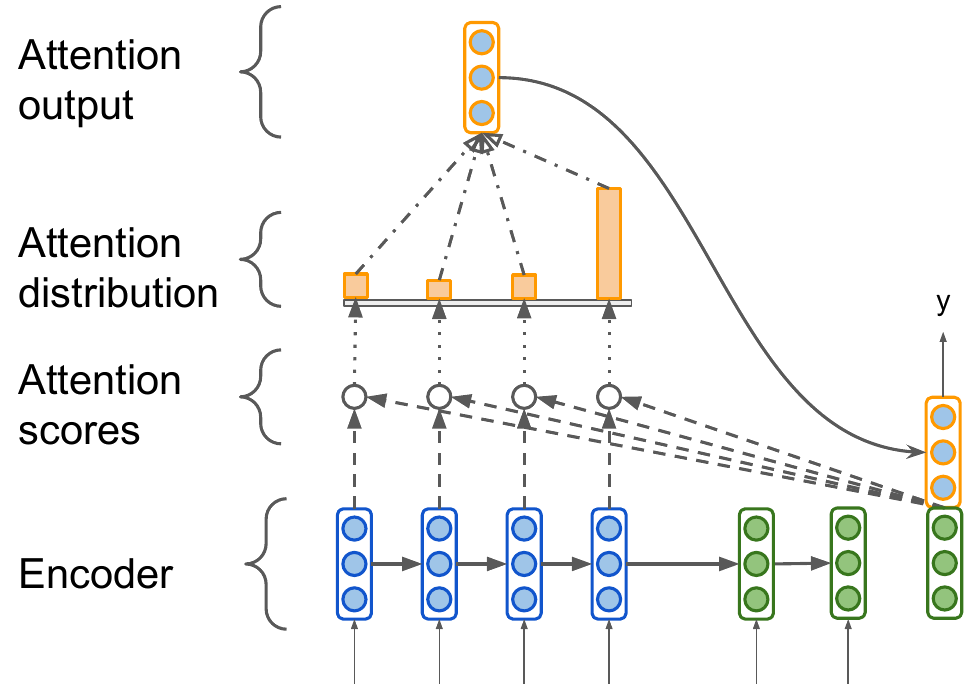

In [35]:
class DecoderAttention(nn.Module):
    
    def __init__(self, hidden_size, output_size, max_seq_len, device='cpu'):
        super(DecoderAttention, self).__init__()
        self._emb = nn.Embedding(num_embeddings=output_size, embedding_dim=hidden_size)
        self._dp = nn.Dropout(0.2)
        self._rnn = nn.GRU( 
                input_size=hidden_size*2, 
                hidden_size=hidden_size, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )
        self._lin = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True,)
        self._device = device
        self._max_seq_len = max_seq_len

        
    def attention(self, enc_h, dec_h):
        att_score = F.softmax( ( enc_h * dec_h.squeeze().unsqueeze(1) ).sum(dim=-1), dim=-1 ) 
        att = ( enc_h * att_score.unsqueeze(-1) ).sum(dim=1).unsqueeze(1)
        return att
        

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0) # количество примеров
        
        # начальное значение входа декодера (0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self._device).fill_(0)
         
        # начальное состояние RNN декодера - конечное состояние енкодера
        decoder_hidden = encoder_hidden
        
        decoder_outputs = [] # история выходов декодера
        
        for i in range(self._max_seq_len): # делаем _max_seq_len шагов
                        
            # считаем новое состояние декодера и его выход
            decoder_output, decoder_hidden  = self.step( decoder_input, decoder_hidden, encoder_outputs )
            decoder_outputs.append(decoder_output) # сохраняем выход
     
            if target_tensor is not None: # режим обучения модели
                # на вход модели вместо её выхода
                # подаём "правильный" выход (teacher forcing)
                decoder_input = target_tensor[:, i].unsqueeze(1) 
            else: # рабочий режим, авторегрессионный метод - подаём выход на вход
                # считаем argmax на выходе модели для всех примеров батча,
                # т.е. выбираем номер слова с наибольшим скором
                _, topi = decoder_output.topk(1) 
                # формируем вектор входа
                decoder_input = topi.squeeze(-1).detach()
        
        # собираем выходы модели на всех итерациях последовательности в тензор
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        # применяем log(softmax(.)) к выходному тензору
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop
        
    
    def step(self, decoder_input, decoder_hidden, encoder_hidden ):
        o = F.relu( self._emb(decoder_input) ) # конвертируем вход в эмбединг
        o = self._dp( o ) # применяем дропаут
        # считаем атеншн, оценка близости всех состояний енкодера и текущего состояния декодера
        att = self.attention( enc_h=encoder_hidden, dec_h=decoder_hidden )
        o = torch.cat([ att, o ], dim=-1 ) # добавляем атеншн ко входу декодера 
        o,h = self._rnn(o, decoder_hidden) # считаем новое состяние декодера ...
        o = self._lin(o) # ... и его выход
        return o,h

---

In [36]:
# # проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
display( device )

device(type='cuda', index=0)

In [37]:
vocab_input_len  = len(ds_train.vocab['Rus'])
vocab_output_len = len(ds_train.vocab['Eng'])
max_output_seq_len = ds_train.max_seq['Eng']+1

In [38]:
embedding_dim = 1024
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocab_len=vocab_input_len+1,
        embedding_dim=embedding_dim,
        encoder_hidden_dim=encoder_hidden_dim,
    ).to(device)

model_decoder = DecoderAttention( 
        hidden_size=encoder_hidden_dim, 
        output_size=vocab_output_len+1, 
        max_seq_len=max_output_seq_len,
        device=device,
    ).to(device)

In [39]:
display( vocab_input_len, vocab_output_len )

29475

13497

In [40]:
display( max(ds_train.vocab['Rus'].values()),  max(ds_train.vocab['Eng'].values()) )

29474

13496

# обучаем 

In [41]:
from torch import optim

learning_rate = 5e-4

encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [42]:
display( len(ds_train) )

111394

In [43]:
loss_history_train = [] # значения ф-ции потери
loss_history_val = [] # значения ф-ции потери

In [44]:
%%time

n_epoch = 64 # количество эпох обучения
batch_size = 512*2

lag_val_check = 4
n_iter_no_check = n_epoch*0.33

assert n_iter_no_check>lag_val_check

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history_train.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
    
    loss_batch = []
    with torch.set_grad_enabled(False):   
        # получаем батч проверочных примеров
        for input_tensor, target_tensor in DataLoader( ds_val, batch_size=batch_size, shuffle=False): 
            encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
            decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.to(device).view(-1)
            )
            loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче

    loss_history_val.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

    if i>n_iter_no_check:
        if ( loss_history_val[-lag_val_check]<loss_history_val[-1] ):
            print( 'validation loss value up, stoped\n' )
            break

  0%|          | 0/64 [00:00<?, ?it/s]

validation loss value up, stoped

CPU times: user 42min 35s, sys: 3.07 s, total: 42min 38s
Wall time: 42min 44s


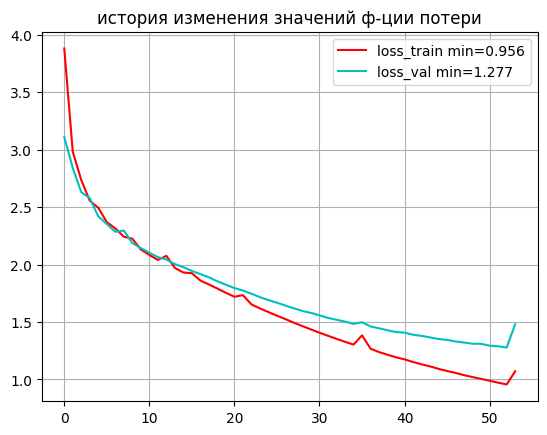

In [45]:
# история изменения значений ф-ции потери
plt.plot(loss_history_train,label='loss_train min=%.3f'%(min(loss_history_train)),c='r')
plt.plot(loss_history_val,label='loss_val min=%.3f'%(min(loss_history_val)),c='c')
plt.grid()
plt.title('история изменения значений ф-ции потери')
plt.legend()

# Тестируем

In [46]:
# from nltk.translate.bleu_score import sentence_bleu
from torchtext.data.metrics import bleu_score

In [47]:
def decode(code,voc): return ' '.join([ voc[c] for c in code if c!=0 ])

In [48]:
voc_ru = { v:k for k,v in ds_train.vocab['Rus'].items() }
voc_en = { v:k for k,v in ds_train.vocab['Eng'].items() }

### на учебном наборе

In [49]:
%%time 

init_seq = []
hypothesis = []
reference = []

with torch.set_grad_enabled(False):
    for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=False): 
        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        init_seq.append( input_tensor.cpu().numpy() )
        
        reference.append( target_tensor.cpu().numpy() )
        
        hypothesis.append( 
            np.swapaxes(np.argmax(
                decoder_outputs.cpu().numpy()
                ,axis=-1,keepdims=True),2,1)
        )

init_seq = np.vstack( init_seq )        
reference = np.vstack( reference )
hypothesis = np.vstack( hypothesis )

display( init_seq.shape, reference.shape, hypothesis.shape, )

(111394, 14)

(111394, 14)

(111394, 1, 14)

CPU times: user 41.4 s, sys: 5.32 s, total: 46.7 s
Wall time: 46.7 s


In [50]:
%%time 

display( bleu_score( reference.astype(str) , hypothesis.astype(str) ) )

0.49598318338394165

CPU times: user 30.9 s, sys: 26.6 ms, total: 30.9 s
Wall time: 31.1 s


In [51]:
df_train_  = pd.DataFrame({
        'Rus': [ decode( v , voc_ru ) for v in tqdm( init_seq) ],
        'Eng_target': [ decode( v , voc_en ) for v in tqdm(reference) ],
        'Eng_predicted': [ decode( v , voc_en ) for v in tqdm( np.squeeze(hypothesis)) ],
    })

display( df_train_.sample(17) )

  0%|          | 0/111394 [00:00<?, ?it/s]

  0%|          | 0/111394 [00:00<?, ?it/s]

  0%|          | 0/111394 [00:00<?, ?it/s]

,Rus,Eng_target,Eng_predicted
78048,"Зима была здесь длинная , а лето короткое . <EOS>",Winter was long here and summer short . <EOS>,was more time every the the . <EOS>
72095,"Ты говорил , что умеешь играть на пианино . <EOS>",You said you could play the piano . <EOS>,said that had play the piano . <EOS>
88249,У них сейчас трое детей . <EOS>,They now have three children . <EOS>,They They have the children children . <EOS>
102289,Я хочу кое о чём с тобой поговорить . <EOS>,There 's something I want to talk to you about...,'s something I talk to talk to you about . <EOS>
73181,Это старая фотография . <EOS>,It 's an old picture . <EOS>,This 's a interesting book . <EOS>
85971,Мальчик пошёл в школу . <EOS>,The boy went to school . <EOS>,boy went to school . <EOS>
57751,Какого размера эти туфли ? <EOS>,What size are these shoes ? <EOS>,What 's are these stamps ? <EOS>
73059,"Полиция арестовала мужчину , <UNK> девушку . <...",The police arrested the man who had murdered t...,police came the news to the got the news . <EOS>
10543,Я не знаю подробностей . <EOS>,I do n't know the details . <EOS>,do n't know the details . <EOS>
16283,У вас нет чего-нибудь поменьше ? <EOS>,Do n't you have anything smaller than this ? <...,n't you have any to than ? ? <EOS>


In [52]:
del init_seq
del hypothesis
del reference

### на тестовом наборе

In [53]:
ds_test = TextPairDataset(df_test, vocab=ds_train.vocab)

  0%|          | 0/13752 [00:00<?, ?it/s]

  0%|          | 0/13752 [00:00<?, ?it/s]

In [54]:
%%time 

init_seq = []
hypothesis = []
reference = []

with torch.set_grad_enabled(False):
    for input_tensor, target_tensor in DataLoader( ds_test, batch_size=batch_size, shuffle=False): 
        encoder_outputs, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs, _, _ = model_decoder(encoder_outputs, encoder_hidden, target_tensor.to(device))
        
        init_seq.append( input_tensor.cpu().numpy() )
        
        reference.append( target_tensor.cpu().numpy() )
        
        hypothesis.append( 
            np.swapaxes(np.argmax(
                decoder_outputs.cpu().numpy()
                ,axis=-1,keepdims=True),2,1)
        )

init_seq = np.vstack( init_seq )        
reference = np.vstack( reference )
hypothesis = np.vstack( hypothesis )

display( init_seq.shape, reference.shape, hypothesis.shape, )

(13752, 14)

(13752, 14)

(13752, 1, 14)

CPU times: user 5.2 s, sys: 676 ms, total: 5.88 s
Wall time: 5.88 s


In [55]:
%%time 

display( bleu_score( reference.astype(str) , hypothesis.astype(str) ) )

0.48168089985847473

CPU times: user 3.71 s, sys: 12.8 ms, total: 3.73 s
Wall time: 3.75 s


In [ ]:
df_test_  = pd.DataFrame({
        'Rus': [ decode( v , voc_ru ) for v in tqdm( init_seq) ],
        'Eng_target': [ decode( v , voc_en ) for v in tqdm(reference) ],
        'Eng_predicted': [ decode( v , voc_en ) for v in tqdm( np.squeeze(hypothesis)) ],
    })

In [60]:
display( df_test_.sample(17) )

,Rus,Eng_target,Eng_predicted
3982,"Я не знал , что он там . <EOS>",I did n't know that he was there . <EOS>,did n't know that he was there . <EOS>
5019,Эта женщина читает . <EOS>,The woman is reading . <EOS>,This woman is reading . <EOS>
12050,<UNK> стрелка сломалась . <EOS>,The hour hand is broken . <EOS>,meeting was the <UNK> . <EOS>
3057,Дождь стучал по <UNK> стеклу . <EOS>,The rain tapped against the window . <EOS>,rain will the the river . <EOS>
4495,Они быстро стали лучшими друзьями . <EOS>,They quickly became best friends . <EOS>,They were have friends friends . <EOS>
3918,"Я купил ручку , но потерял её . <EOS>","I bought a pen , but I lost it . <EOS>","bought a letter , but I lost her . <EOS>"
12225,Увидимся вечером . <EOS>,See you tonight . <EOS>,I you last . <EOS>
1500,Он стремится стать учителем . <EOS>,He aspires to become a teacher . <EOS>,He made to become a teacher . <EOS>
7470,Мы катались на лодке . <EOS>,We rode on a boat . <EOS>,We 're on the tree . <EOS>
3744,В последние годы наука достигла значительного ...,"In recent years , science has made remarkable ...",the <UNK> of the <UNK> become a progress . <EOS>


In [57]:
del init_seq
del hypothesis
del reference

---

In [58]:
# from torchtext.data.metrics import bleu_score

# candidate_corpus = [
#     ['My', 'full', 'pytorch', 'test'], 
#     ['Another', 'Sentence']
# ]

# references_corpus = [
#     [
#         ['My', 'full', 'pytorch', 'test'], 
#         ['Completely', 'Different']
#     ], [
#         ['No', 'Match']
#     ]
# ]

# bleu_score(candidate_corpus, references_corpus)

In [59]:
# from nltk.translate.bleu_score import sentence_bleu

# hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
# reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']

# # hypothesis = [ '0', '1', '2', '3', '4', '6']
# # reference = [ '0', '1', '2', '3',  '5', '7', '6' ]

# bleu_score([hypothesis], [[reference,]])

---

In [ ]:
# batch_size=4
# for input_tensor, target_tensor in DataLoader( ds_train, batch_size=batch_size, shuffle=True): break
# display( input_tensor.shape, target_tensor.shape )

In [ ]:
# vocab_input_len  = len(ds_train.vocab['Rus'])
# vocab_output_len = len(ds_train.vocab['Eng'])
# max_output_seq_len = ds_train.max_seq['Eng']+1
# embedding_dim = 1024
# encoder_hidden_dim = 256

# model_encoder = Encoder(
#         vocab_len=vocab_input_len+1,
#         embedding_dim=embedding_dim,
#         encoder_hidden_dim=encoder_hidden_dim,
#     )

# model_decoder = DecoderAttention( 
#         hidden_size=encoder_hidden_dim, 
#         output_size=vocab_output_len+1, 
#         max_seq_len=max_output_seq_len,
#         device='cpu',
#     )

# with torch.set_grad_enabled(False): 
#     enc_o, enc_h = model_encoder(input_tensor)
#     # dec_h = enc_h 
#     # dec_i = target_tensor[:,0].unsqueeze(1)
#     # dec_o, dec_h = model_decoder.step(dec_i, dec_h, enc_o)
#     dec_o, dec_h, _ = model_decoder(enc_o,enc_h)

# display( dec_o.shape, dec_h.shape )

# #   display( att.shape, o.shape  )

# # display( ( decoder_input.shape, decoder_hidden.shape, encoder_hidden.shape )  )


In [ ]:
# dec_h = enc_h[:,-1,:].unsqueeze(0)
# dec_h.shape